# **Task P8**
## Analyzing Twitter Data using NLP

##### This task focuses on analyzing user replies to Covid-19 news published on the social media platform X (formerly known as Twitter) using some basic natural language processing (NLP) techniques. 

##### The task uses the `replies.csv` dataset, which contains the information about user replies to the Covid-19 news posted on Twitter. The columns capture the content related to the individual replies such as `text` (the actual text content of the reply), `id` (a unique ID for the reply itself), `conversation_id` (linking the reply to a specific conversation thread), `in_reply_to_user_id` (identifying the target user of the reply), and `possibly_sensitive` (indicating if the content may be sensitive). Additional informaiton include `author_id` (the unique ID of the reply's author), `author_followers` (the count of the author's followers),`author_tweets` (total tweets made by the author), and `author_location` (the geographical location of the author). Moreover, engagement metrics are tracked through columns like `retweets`, `replies`, `likes`, and `quote_count`. Time and location metadata are captured by `created_at` and `geo`, respectively, with `account` specifying the account name of the news publishers (e.g., BBC).

<img src="pic.png" alt="SIT112 News Tweets!" width="1800" height="200">

### A. Instructions

1. `To complete this task, you must first study the solution notebook; then try to do it yourself. You can copy the solutions into ChatGPT and ask for clarification or more examples.`
2. Complete and submit the TaskCompletionReport form in PDF format using Ontrack. You can do this by the end of Week 12, but feedback will only be provided for submissions received by 11 AM of the due date.
3. Do **not** include the solution (yours or the one provided to you) in your submission.
4. The workshops are the primary venue for you to seek help if you need any clarification/assitance. The tutors are there to help you complete and submit the tasks. Please avoid emailing your code or screenshots to the tutors outside workshop hours. 
5. Consider using online resources such as ChatGPT to strenghten your undertanding of the task. 

Good luck :)

In [4]:
import importlib
import subprocess

# The following lines should install all libraries you need - you can install the libraries manually if the script did not work 
required_modules = ['pandas', 'seaborn', 'matplotlib', 'numpy', 'datetime', 'sklearn', 'nltk', 'textblob', 'textblob', 'collections', 'numpy', 'warnings']
for module in required_modules:
    try:
        importlib.import_module(module)
    except ImportError:
        print(f"{module} module not found. Installing...")
        subprocess.check_call(['pip', 'install', module])

print("All required modules are installed.")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import datetime as dt
from collections import Counter
import re
import warnings
import nltk
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
# Set the maximum number of columns and rows displayed
pd.set_option('display.max_columns', None)  # None means no limit
pd.set_option('display.max_rows', None)  # None means no limit
# You can also adjust the width of each column and the maximum column width
pd.set_option('display.max_colwidth', None)  # None means no truncation on column width

All required modules are installed.


### B. Write Python code that performs (answers) the following operations (questions) 

##### 1. Read the data from the .csv file into a DataFrame and display the first five rows.

In [5]:
# write your code here
tdf = pd.read_csv('replies.csv')
tdf.head()

,author_id,author_followers,author_tweets,author_location,id,conversation_id,source,in_reply_to_user_id,possibly_sensitive,text,created_at,geo,retweets,replies,likes,quote_count,account
0,2,1,3827,NaN,1.480000e+18,1.480000e+18,NaN,2.604917e+07,False,@RobinLaRoca @guardian I don't want a payment.\nI want the unvaxxed to pay every last red cent for public hospital treatment rendered to them,2022-01-01T03:31:03Z,NaN,0,2,0,0,guardian
1,3,939,49244,Sheffield,1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,@guardian I'm fine with that as long as they backdate the payments for everyone.,2022-01-01T00:42:39Z,{'place_id': '07e9c7d1954fff64'},0,1,0,0,guardian
2,4,318,4519,"Santiago, Chile",1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,"@guardian Yes, for big pharma",2022-01-01T00:37:59Z,NaN,1,0,1,0,guardian
3,5,2812,320641,Earth,1.480000e+18,1.480000e+18,NaN,1.367531e+06,False,@FoxNews a vaccine most Missourians won’t take,2022-01-01T07:39:51Z,NaN,0,0,5,0,FoxNews
4,6,350,1581,"Conway, AR",1.480000e+18,1.480000e+18,NaN,1.190000e+18,False,"@nikki6ixx1 @FoxNews I currently have Covid, im non vaccinated and feeling perfectly fine. Please explain to me how am I going to die because of this virus??",2022-01-01T13:30:39Z,NaN,0,2,0,0,FoxNews


##### 2. Clean the reply texts as listed below. You can use ChatGPT to generate regular expressions for these cleaning operations. 

- Remove @ Mentions: Strip out any @ mentions in the reply texts, which typically refer to other users and are not relevant for general analysis.
- Remove Hashtags: Eliminate the '#' symbol but keep the subsequent text, which might be relevant for understanding the topic of the reply.
- Remove Retweet Indicators: Remove any 'RT' symbols used to indicate retweets, as they do not contribute to text content.
- Remove URLs: Strip out any web links (URLs), which are common in reply texts but irrelevant to text analysis.
- Remove Punctuation: Eliminate all punctuation marks to reduce variability in the reply texts.
- Convert to Lowercase: Standardize all reply texts to lowercase to ensure uniformity in the analysis.

In [12]:
import pandas as pd
import re


# Display the first few rows of the dataframe
print("Original Data:")
print(tdf.head())

# Function to clean reply texts
def clean_reply_text(text):
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (but keep the text)
    text = re.sub(r'#', '', text)
    
    # Remove retweet indicators
    text = re.sub(r'\bRT\b', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Apply the cleaning function to the 'text' column
tdf['cleaned_text'] = tdf['text'].apply(clean_reply_text)

# Display the cleaned data
print("\nCleaned Data:")
print(tdf[['text', 'cleaned_text']].head())

# Save cleaned data to a new CSV file
tdf.to_csv('cleaned_data.csv', index=False)  # Replace 'cleaned_data.csv' with the desired output file name


Original Data:
   author_id  author_followers  author_tweets  author_location            id  \
0          2                 1           3827              NaN  1.480000e+18   
1          3               939          49244        Sheffield  1.480000e+18   
2          4               318           4519  Santiago, Chile  1.480000e+18   
3          5              2812         320641            Earth  1.480000e+18   
4          6               350           1581       Conway, AR  1.480000e+18   

   conversation_id  source  in_reply_to_user_id  possibly_sensitive  \
0     1.480000e+18     NaN         2.604917e+07               False   
1     1.480000e+18     NaN         8.781841e+07               False   
2     1.480000e+18     NaN         8.781841e+07               False   
3     1.480000e+18     NaN         1.367531e+06               False   
4     1.480000e+18     NaN         1.190000e+18               False   

                                                                             

##### 3. Remove from the reply texts the stopwords and the custom list of words that are unwanted:

- Utilize a list of predefined stopwords from NLTK tailored for the English language (from nltk.corpus import stopwords).
- Define a custom list of words to be excluded that are specifically irrelevant or overused in the reply texts.
- Remove stopwords and custom words: filter out these words from the (reply) text to focus on more meaningful words for analysis.

In [17]:
# Write your code here

# Load NLTK's predefined stopwords for English
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define custom list of words to be excluded
custom_words = ['custom_word1', 'custom_word2', 'custom_word3']  # Add your custom words here

# Combine NLTK stopwords and custom words
excluded_words = stop_words.union(custom_words)

# Display the first few rows of the dataframe
print("Original Data:")
print(tdf.head())

# Function to clean reply texts
def clean_reply_text(text):
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (but keep the text)
    text = re.sub(r'#', '', text)
    
    # Remove retweet indicators
    text = re.sub(r'\bRT\b', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords and custom words
    cleaned_text = ' '.join(word for word in text.split() if word not in excluded_words)
    
    return cleaned_text

# Apply the cleaning function to the 'text' column
tdf['cleaned_text'] = tdf['text'].apply(clean_reply_text)

# Display the cleaned data
print("\nCleaned Data:")
print(tdf[['text', 'cleaned_text']].head())


Original Data:
   author_id  author_followers  author_tweets  author_location            id  \
0          2                 1           3827              NaN  1.480000e+18   
1          3               939          49244        Sheffield  1.480000e+18   
2          4               318           4519  Santiago, Chile  1.480000e+18   
3          5              2812         320641            Earth  1.480000e+18   
4          6               350           1581       Conway, AR  1.480000e+18   

   conversation_id  source  in_reply_to_user_id  possibly_sensitive  \
0     1.480000e+18     NaN         2.604917e+07               False   
1     1.480000e+18     NaN         8.781841e+07               False   
2     1.480000e+18     NaN         8.781841e+07               False   
3     1.480000e+18     NaN         1.367531e+06               False   
4     1.480000e+18     NaN         1.190000e+18               False   

                                                                             

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sakshambehal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### 4. What are the 5 most frequent words in the replies per account (news publisher, e.g., BBC)?

In [19]:
# Write your code here
from collections import Counter
from nltk.tokenize import word_tokenize

# Function to find the 5 most frequent words in the replies per account
def top_frequent_words(df):
    top_words_per_account = {}
    for account, group in df.groupby('account'):
        # Tokenize the cleaned reply texts
        tokenized_text = ' '.join(group['cleaned_text']).split()
        
        # Count the frequency of each word
        word_freq = Counter(tokenized_text)
        
        # Get the 5 most frequent words
        top_words = word_freq.most_common(5)
        
        # Store the results
        top_words_per_account[account] = top_words
    
    return top_words_per_account

# Get the 5 most frequent words in the replies per account
top_words = top_frequent_words(tdf)

# Display the results
for account, words in top_words.items():
    print(f"Top 5 words for {account}:")
    for word, freq in words:
        print(f"{word}: {freq} times")
    print()

Top 5 words for 9NewsAUS:
dont: 45 times
vaccine: 38 times
get: 38 times
like: 34 times
covid: 29 times

Top 5 words for BBCWorld:
covid: 108 times
people: 105 times
vaccine: 99 times
dont: 95 times
get: 93 times

Top 5 words for CBC:
go: 3 times
lies: 3 times
every: 2 times
day: 2 times
news: 2 times

Top 5 words for CNN:
people: 381 times
covid: 327 times
get: 305 times
vaccine: 300 times
dont: 294 times

Top 5 words for FoxNews:
people: 567 times
covid: 478 times
get: 478 times
vaccine: 462 times
dont: 437 times

Top 5 words for MSNBC:
people: 87 times
vaccine: 35 times
dont: 35 times
get: 32 times
amp: 31 times

Top 5 words for SkyNews:
people: 129 times
covid: 107 times
dont: 103 times
vaccine: 100 times
vaccinated: 78 times

Top 5 words for guardian:
people: 54 times
vaccine: 36 times
dont: 31 times
like: 25 times
need: 24 times

Top 5 words for timesofindia:
vaccine: 25 times
people: 15 times
modi: 14 times
ao2022: 12 times
novakdjokovic: 12 times



##### 5. Classify the sentiment of each reply as positive, negative, or neutral based on the `text` column. Then visualize the ratio of the replies with positive, negative, or neutral sentiments per news publisher (account). 


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sakshambehal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


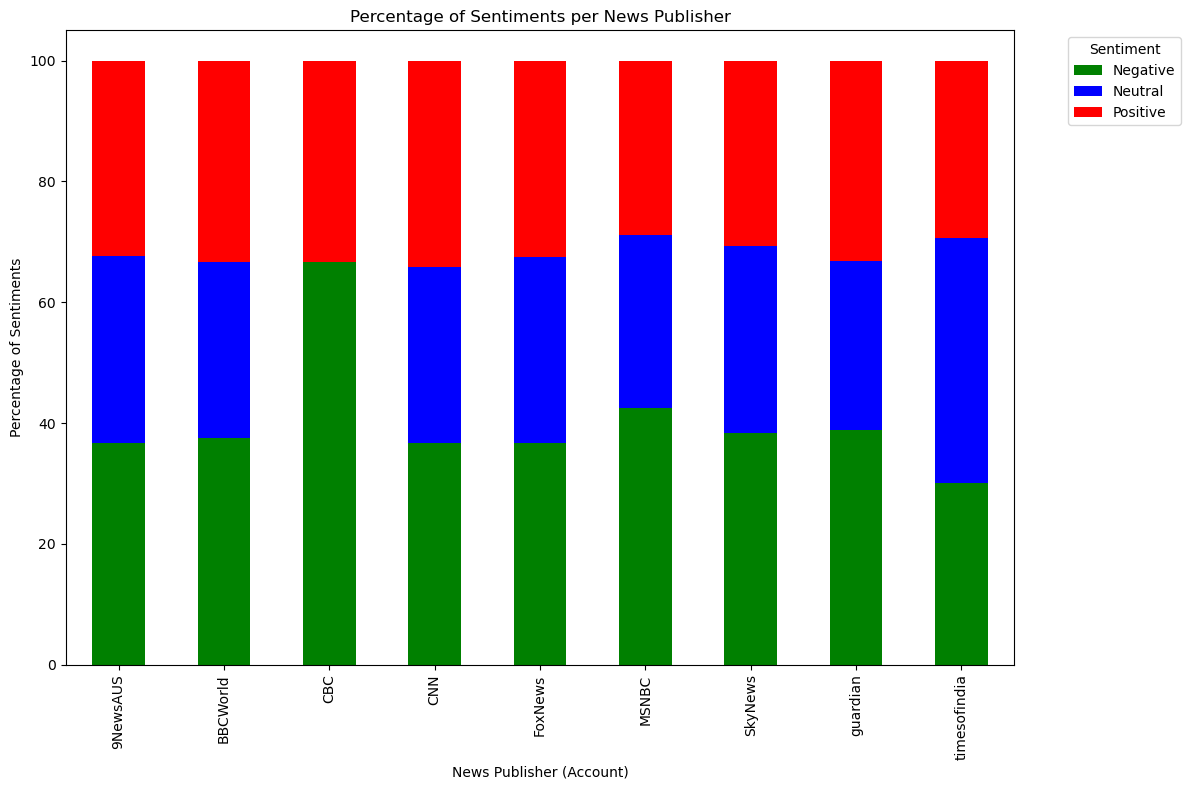

In [27]:
# Write your code here
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the cleaned dataset
tdf = pd.read_csv('cleaned_data.csv')  # Replace 'cleaned_data.csv' with the actual cleaned data file name

# Download NLTK's VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify the sentiment of each reply
def classify_sentiment(text):
    # Get the sentiment score for the text
    sentiment_score = sia.polarity_scores(text)
    
    # Determine the sentiment label based on the compound score
    if sentiment_score['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to classify sentiment for each reply
tdf['sentiment'] = tdf['cleaned_text'].apply(classify_sentiment)

# Group the data by the 'account' column and then count the occurrences of each sentiment
# This aggregates the sentiment data per account, normalizing the counts to get proportions
account_sentiments = tdf.groupby('account')['sentiment'].value_counts(normalize=True).unstack(fill_value=0)

# Multiply by 100 to convert proportions to percentages
# This adjustment makes the data more interpretable in the bar plot
account_sentiments = account_sentiments * 100

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
# Create a stacked bar plot to show the proportion of each sentiment by account
account_sentiments.plot(kind='bar', stacked=True, color=['green', 'blue', 'red'], ax=ax)
plt.title('Percentage of Sentiments per News Publisher')
plt.xlabel('News Publisher (Account)')
plt.ylabel('Percentage of Sentiments')
# Place the legend outside the plot area for better clarity
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### C. Learn more
* https://www.sciencedirect.com/science/article/pii/S2468696423000125
* https://youtu.be/toM78JGJ_4s?si=8ESJ-yOV_H1iX74r
* https://youtu.be/QpzMWQvxXWk?si=CPvNgnZo3jsW4HL5
* https://youtu.be/o7OqhzMcDfs?si=9iFeYZq4TlVCMMRb